In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [100]:
def createGreenTaxiDataset(year):
  dfs = []
  for i in range(1,13):
    df = pd.read_parquet(f'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_{year}-{str(i).zfill(2)}.parquet')
    dfs.append(df)
  
  return pd.concat(dfs)

In [101]:
df = createGreenTaxiDataset(2021)

In [102]:
def getTripDuration(df):
  df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).apply(lambda x: x.total_seconds() / 60)
  return df

In [103]:
df = getTripDuration(df)
df = df.loc[(df.duration > 0) & (df.duration <= 60)]

<Axes: xlabel='duration', ylabel='Count'>

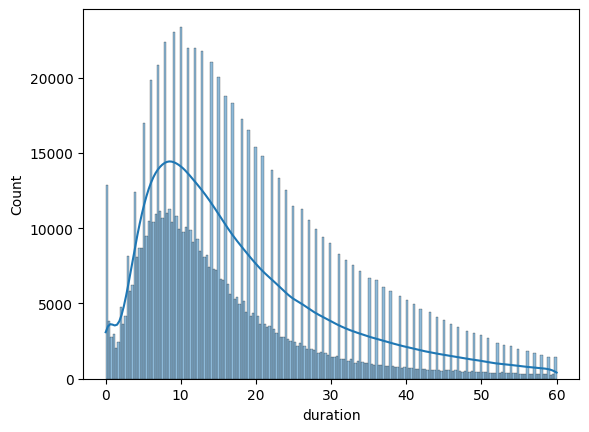

In [110]:
sns.histplot(df, x='duration', kde=True)

In [111]:
def formatTrainingInputs(df):
  # define input types
  numerical = ['trip_distance']
  categorical = ['PULocationID', 'DOLocationID']
  df[categorical] = df[categorical].astype(str)

  # one-hot encoding for categorical variables
  df_dicts = df[categorical + numerical].to_dict(orient='records')
  dv = DictVectorizer()
  X = dv.fit_transform(df_dicts)

  return X


In [113]:
X = formatTrainingInputs(df)
y = df.duration

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)